<a href="https://colab.research.google.com/github/ykato27/Auto-Encorder/blob/main/VAE_Pyro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## VAE-Pyro

In [1]:
!pip install pyro-ppl

     |████████████████████████████████| 678 kB 7.6 MB/s 


In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.contrib.examples.util import MNIST

In [3]:
pyro.set_rng_seed(10)

### データの準備

In [4]:
def setup_data_loaders(batch_size=128, use_cuda=False):
    root = "./data"
    download=True
    trans = transforms.ToTensor()
    train_set = MNIST(root=root, train=True, transform=trans, download=download)
    test_set = MNIST(root=root, train=False, transform=trans)
    kwargs = {"num_workers": 2, "pin_memory":use_cuda}
    train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False, **kwargs)
    return train_loader, test_loader

### モデル

In [5]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        # 全結合層
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 784)
        # 活性化関数
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        hidden = self.softplus(self.fc1(x))
        # 各出力がベルヌーイ分布のパラメータになる→大きいほど黒に近くなる
        loc_img = self.sigmoid(self.fc2(hidden))
        # 画像を出力
        return loc_img

In [6]:
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        # 入力-中間層間の全結合層
        self.fc1 = nn.Linear(784, hidden_dim)
        # 中間-出力層間の全結合層
        self.fc21 = nn.Linear(hidden_dim, z_dim) # 平均用
        self.fc22 = nn.Linear(hidden_dim, z_dim) # 分散用
        # 活性化関数の準備
        self.softplus = nn.Softplus()
    def forward(self, x):
        # 入力の次元を修正（28×28=784）
        x = x.reshape(-1, 784)
        hidden = self.softplus(self.fc1(x))
        # 各ピクセル値が従う正規分布の平均、分散を出力
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale

In [7]:
class VAE(nn.Module):
    def __init__(self, z_dim=50, hidden_dim = 400, use_cuda=True):
        super().__init__()
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)
        if use_cuda:
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim
    def model(self, x):
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            loc_img = self.decoder(z)
            pyro.sample("obs", dist.ContinuousBernoulli(loc_img).to_event(1), obs=x.reshape(-1, 784))
    def guide(self, x):
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            z_loc, z_scale = self.encoder(x)
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
    def reconstruct_img(self, x):
        z_loc, z_scale = self.encoder(x)
        z = dist.Normal(z_loc, z_scale).sample()
        loc_img = self.decoder(z)
        return img

### 学習

In [8]:
# 訓練データによる学習
def train(svi, train_loader, use_cuda=True):
    epoch_loss = 0
    for x,_ in train_loader:
        if use_cuda:
            x = x.cuda()
        epoch_loss += svi.step(x)
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss/normalizer_train
    return total_epoch_loss_train

In [9]:
# テストデータでのELBOの評価
def evaluate(svi, test_loader, use_cuda=True):
    test_loss = 0
    for x,_ in test_loader:
        if use_cuda:
            x = x.cuda()
        test_loss += svi.evaluate_loss(x)
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss/normalizer_test
    return total_epoch_loss_test

In [10]:
USE_CUDA = True
LEARNING_RATE = 1.0e-3
NUM_EPOCHS = 100
TEST_FREQUENCY = 5
train_loader, test_loader = setup_data_loaders(batch_size=256, use_cuda=USE_CUDA)
pyro.clear_param_store() #pyroに登録されているパラメータを一旦消し去ります。
vae = VAE(use_cuda=USE_CUDA)
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())
train_elbo = []
test_elbo = []
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch %03d] average training loss: %.4f" %(epoch, total_epoch_loss_train))
    if epoch % TEST_FREQUENCY == 0:
        total_epoch_loss_test = evaluate(svi, test_loader, use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        print("[epoch %03d] average test loss: %.4f" %(epoch, total_epoch_loss_test))


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


[epoch 000] average training loss: -1309.1092
[epoch 000] average test loss: -1491.4668
[epoch 001] average training loss: -1564.3515
[epoch 002] average training loss: -1651.9781
[epoch 003] average training loss: -1699.1390
[epoch 004] average training loss: -1729.5980
[epoch 005] average training loss: -1753.5958
[epoch 005] average test loss: -1767.5297
[epoch 006] average training loss: -1769.6990
[epoch 007] average training loss: -1781.1739
[epoch 008] average training loss: -1790.0719
[epoch 009] average training loss: -1797.2005
[epoch 010] average training loss: -1802.9566
[epoch 010] average test loss: -1808.7515
[epoch 011] average training loss: -1807.8847
[epoch 012] average training loss: -1811.9391
[epoch 013] average training loss: -1815.4741
[epoch 014] average training loss: -1818.5410
[epoch 015] average training loss: -1821.2268
[epoch 015] average test loss: -1824.9259
[epoch 016] average training loss: -1823.5791
[epoch 017] average training loss: -1825.6770
[epo

### 可視化

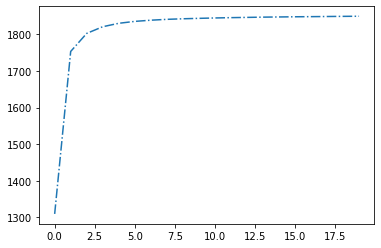

In [11]:
import matplotlib.pyplot as plt
plt.plot(train_elbo[::5],"-.")
plt.show()

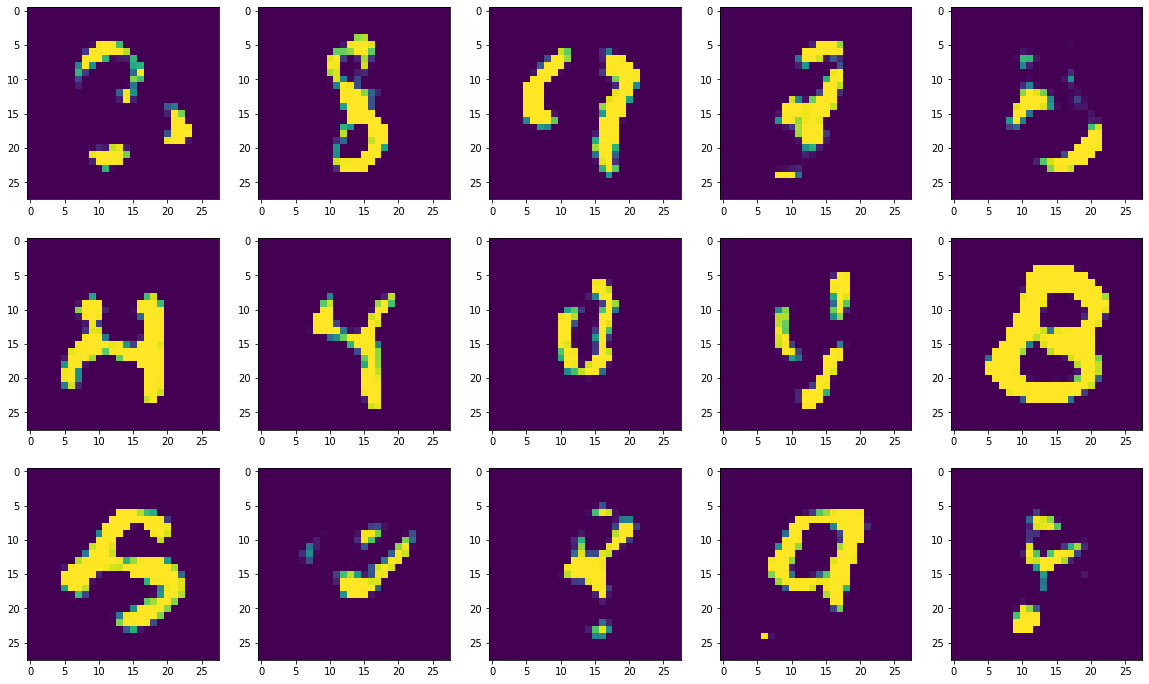

In [12]:
fig, ax = plt.subplots(nrows = 3, ncols=5, figsize=(20,12))
for r in range(3):
    for c in range(5):
        ax[r,c].imshow(vae.decoder(torch.randn(50).cuda()).detach().cpu().numpy().reshape(28,28))